https://github.com/AILAB-CEFET-RJ/cic1205/blob/d593e7c3e78b8beeeaadad76a1f09685eaaa06d1/notebooks/data_imbalance.ipynb#L100

#### Fazendo a primeira análise do dataset

In [78]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

df = pd.read_csv('aug_train.csv')

df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,17163,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,32023,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,87447,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,501933,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


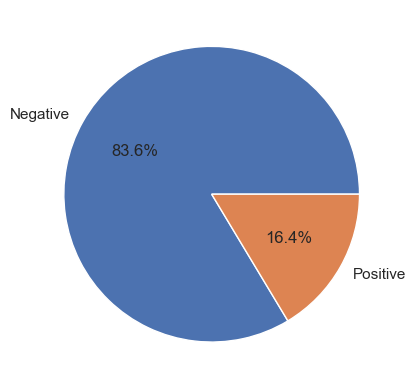

In [79]:
df = pd.get_dummies(df, ['Gender', 'Vehicle_Age', 'Vehicle_Damage'])

negative_class = df[df['Response'] == 0]
positive_class = df[df['Response'] == 1]

negative_class_size = negative_class.shape[0]
positive_class_size = positive_class.shape[0]

plt.pie([negative_class_size, positive_class_size], labels=['Negative', 'Positive'], autopct='%1.1f%%')
plt.show()

#### Amostragem uniforme da classe negativa

In [80]:
negative_class_sample = negative_class.sample(n=positive_class_size, random_state=42)
balanced_df = pd.concat([negative_class_sample, positive_class])

# Misturando os dados
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_df['Response'].value_counts()

Response
0    62601
1    62601
Name: count, dtype: int64

#### Treinamento de um modelo inicial

In [81]:
# Separando as features do target
X = balanced_df.drop(columns=['id', 'Response'])
y = balanced_df['Response']

X.columns = ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 
             'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Gender_Female',
             'Gender_Male', 'Vehicle_Age_1_2_Year', 'Vehicle_Age_lessthan_1_Year',
             'Vehicle_Age_greaterthan_2_Years', 'Vehicle_Damage_No', 'Vehicle_Damage_Yes']

# Separando os dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Predição com o Modelo Inicial

In [82]:
primary_X = df.drop(columns=['id', 'Response'])
primary_y = df['Response']

primary_X.columns = ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 
             'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Gender_Female',
             'Gender_Male', 'Vehicle_Age_1_2_Year', 'Vehicle_Age_lessthan_1_Year',
             'Vehicle_Age_greaterthan_2_Years', 'Vehicle_Damage_No', 'Vehicle_Damage_Yes']


# Teste no dataframe que foi balanceado
undersampled_test = xgb_classifier.predict(X_test)
print("Accuracy of Undersampled Test Set:", round(accuracy_score(y_test,undersampled_test) * 100, 2 ), "%")

# Teste no dataframe original
test = xgb_classifier.predict(primary_X)
print("Accuracy of Test Set:", round(accuracy_score(primary_y,test) * 100, 2 ), "%")

Accuracy of Undersampled Test Set: 83.91 %
Accuracy of Test Set: 78.71 %


In [83]:
# Obtendo as probabilidades de result ser positivo
test_prob = xgb_classifier.predict_proba(primary_X)[:,1]
df_with_prob = df.copy()
df_with_prob['Positive_Prob'] = test_prob
df_with_prob.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes,Positive_Prob
0,167647,22,1,7.0,1,2630.0,152.0,16,0,False,True,False,True,False,True,False,0.001535
1,17163,42,1,28.0,0,43327.0,26.0,135,0,False,True,True,False,False,False,True,0.872374
2,32023,66,1,33.0,0,35841.0,124.0,253,0,True,False,True,False,False,False,True,0.487919
3,87447,22,1,33.0,0,27645.0,152.0,69,0,True,False,False,True,False,True,False,0.117302
4,501933,28,1,46.0,1,29023.0,152.0,211,0,False,True,False,True,False,True,False,0.000376


#### Normalização da Probabilidade

In [86]:
# Calculando a média das probabilidades
w = df_with_prob['Positive_Prob'].mean()

# Calculando a taxa de amostragem
total_negative = df[df['Response'] == 0].shape[0]
sampled_negative = negative_class_sample.shape[0]
r = sampled_negative / total_negative

# Normalizando a probabilidade para as amostras negativas
df_with_prob['Normalized_Prob'] = df_with_prob.apply(
    lambda row: (r * row['Positive_Prob']) / w if row['Response'] == 0 else row['Positive_Prob'],
    axis=1
)

df_with_prob[['Response', 'Positive_Prob', 'Normalized_Prob']].head()

,Response,Positive_Prob,Normalized_Prob
0,0,0.001535,0.000945
1,0,0.872374,0.536783
2,0,0.487919,0.300223
3,0,0.117302,0.072177
4,0,0.000376,0.000231


#### Filtragem das Amostras Negativas

In [89]:
# Filtra as amostras negativas com base nas probabilidades normalizadas
def filter_negative_samples(row):
    if row['Response'] == 0:
        u = np.random.uniform(0, 1)
        return u < row['Normalized_Prob']
    return True

df_filtered = df_with_prob[df_with_prob.apply(filter_negative_samples, axis=1)]

print("Número de amostras antes da filtragem: ", df.shape[0])
print("Número de amostras após a filtragem: ", df_filtered.shape[0])
df_filtered[['id', 'Response', 'Positive_Prob', 'Normalized_Prob']].head()

Número de amostras antes da filtragem:  382154
Número de amostras após a filtragem:  107753


,id,Response,Positive_Prob,Normalized_Prob
3,87447,0,0.117302,0.072177
6,71711,0,0.784205,0.482532
9,344792,1,0.829739,0.829739
12,441774,1,0.911577,0.911577
14,441575,1,0.851933,0.851933
